In [ ]:
import os
from google.colab import drive
from google.colab import files
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras import Model
import matplotlib.pyplot as plt
import math
import shutil

# Pulls the data from my personal Google Drive folder

In [ ]:
mkdir Week6_Data

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
cp -a drive/MyDrive/'Joao Pedro Zanlorensi Cardoso'/Week6_Data/. /content/Week6_Data

In [ ]:
ls

drive/  sample_data/  Week6_Data/


In [ ]:
cd Week6_Data

/content/Week6_Data


In [ ]:
# Bash script to unzip the tar (compressed) folders
%%bash
for f in *
do
  echo "Processing $f"
  tar -xf $f
  echo "Done"
done

Processing Accipitridae.tar.gz
Done
Processing Cathartidae.tar.gz
Done
Processing Falconidae.tar.gz
Done
Processing Pandionidae.tar.gz
Done
Processing Strigidae.tar.gz
Done
Processing Tytonidae.tar.gz
Done


In [ ]:
# Bash script to delete all tar (compressed) folders now that we have the true data

In [ ]:
%%bash
find . -name "*.tar.gz" -type f -delete

# Splits Train and Test datasets

In [ ]:
%%bash
mkdir model
cd model
mkdir train
mkdir test
mkdir validation

In [ ]:
directories = os.listdir()
directories.remove('model')
try:
  directories.remove('.ipynb_checkpoints')
except:
  print('No iPython checkpoints to remove from the list of directories')

No iPython checkpoints to remove from the list of directories


In [ ]:
bird_families = directories

os.chdir('/content/Week6_Data')

train_directory = '/content/Week6_Data/model/train'
val_directory = '/content/Week6_Data/model/validation'
test_directory = '/content/Week6_Data/model/test'

for bird_family in bird_families:
  os.chdir(train_directory)
  os.mkdir(bird_family)
  os.chdir(test_directory)
  os.mkdir(bird_family)
  os.chdir(val_directory)
  os.mkdir(bird_family)

In [ ]:
os.chdir('/content/Week6_Data')

for bird_family in bird_families:
  os.chdir(bird_family)

  family_species = os.listdir()

  for specie in family_species:
    os.chdir(specie)

    pictures = os.listdir()
    qt_pictures = len(pictures)

    qt_train_pictures = math.ceil(0.49 * qt_pictures)
    qt_val_pictures = math.ceil(0.21 * qt_pictures)
    
    for idx, picture in enumerate(pictures):
      
      original_picture_name = picture
      specie = specie.replace('_', '-')
      concat_pic_name = specie + '_' + str(idx)
      concat_pic_name = concat_pic_name.replace(' ', '')
      concat_pic_name = concat_pic_name.replace('(', '')
      concat_pic_name = concat_pic_name.replace(')', '')
      new_pic_name = concat_pic_name
      os.rename(original_picture_name, new_pic_name)
      picture_name = new_pic_name

      file_to_copy = os.getcwd() + '/' + picture_name

      if idx+1 >= qt_train_pictures:
        if idx+1 >= (qt_train_pictures + qt_val_pictures):
          # copy picture to the test directory for the specific bird family
          shutil.copyfile(file_to_copy, test_directory + '/' + bird_family + '/' + picture_name + '.jpg')
        else:
          # copy picture to the validation directory for the specific bird family
          shutil.copyfile(file_to_copy, val_directory + '/' + bird_family + '/' + picture_name + '.jpg')
      else:
        # copy picture to the train directory for the specific bird family
        shutil.copyfile(file_to_copy, train_directory + '/' + bird_family + '/' + picture_name + '.jpg')
        
    os.chdir('..')

  os.chdir('..')

In [ ]:
cd model

/content/Week6_Data/model


## Using the DL Model that was applied in the last lab (week 5) to classify the images

In [ ]:
# Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen = ImageDataGenerator(
                horizontal_flip=True,
                rescale = (1./128) - 1 # Normalization between -1,1
              )

datagen_test = ImageDataGenerator(
                rescale = (1./128) - 1
              )
batch_size = 32

# Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
train_batches = datagen.flow_from_directory('train/', batch_size=batch_size, class_mode = 'categorical', target_size=(224, 224))
val_batches = datagen_test.flow_from_directory('validation/', batch_size=batch_size, class_mode = 'categorical', target_size=(224, 224))
test_batches = datagen_test.flow_from_directory('test/', batch_size=batch_size, class_mode = 'categorical', target_size=(224, 224))

Found 20787 images belonging to 6 classes.
Found 8941 images belonging to 6 classes.
Found 12746 images belonging to 6 classes.


In [ ]:
# Functions to calculate accuracy metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

In [ ]:
def get_model(optimizer):
  
  model = Sequential()

  # Adding the network layers
  model.add(layers.Conv2D(32, kernel_size=(5, 5),
                   strides=(2, 2), 
                   padding='valid',
                   input_shape=(None,None,15)))
  
  model.add(layers.BatchNormalization(axis=3, scale=False))
  
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), 
                   padding='valid',))
  
  model.add(layers.BatchNormalization(axis=3, scale=False))
  
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(64, kernel_size=(5, 5),
                   strides=(2, 2), 
                   padding='valid',
                  ))
  
  model.add(layers.BatchNormalization(axis=3, scale=False))
  
  model.add(layers.Activation('relu'))
  
  model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  model.add(layers.Conv2D(64, kernel_size=(3, 3),
                   strides=(2, 2), 
                 padding='valid',
                 ))
  
  model.add(layers.BatchNormalization(axis=3, scale=False))
  
  model.add(layers.Activation('relu'))

  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), 
                   padding='valid'))
  
  model.add(layers.BatchNormalization(axis=3, scale=False))
  
  model.add(layers.Activation('relu'))

  model.add(layers.Flatten())
  
  model.add(layers.Dense(n_classes, activation='softmax'))
  
  model.summary()
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_m, recall_m, precision_m])

  return model

In [ ]:
optimizer = 'Nadam'

n_classes = train_batches.num_classes

images_per_class_train = np.floor(train_batches.samples/n_classes)
images_per_class_val = np.floor(val_batches.samples/n_classes)

qt_epochs = 5

model = get_model(optimizer)

hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=qt_epochs,
                validation_data = val_batches,
                validation_steps= images_per_class_val * n_classes / batch_size,               
  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization_5 (Batc  (None, 110, 110, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 110, 110, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 32)        25632     
                                                                 
 batch_normalization_6 (Batc  (None, 53, 53, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 53, 53, 32)       

## Displaying the learning curve and the confusion matrix

Reference: https://vitalflux.com/python-keras-learning-validation-curve-classification-model/


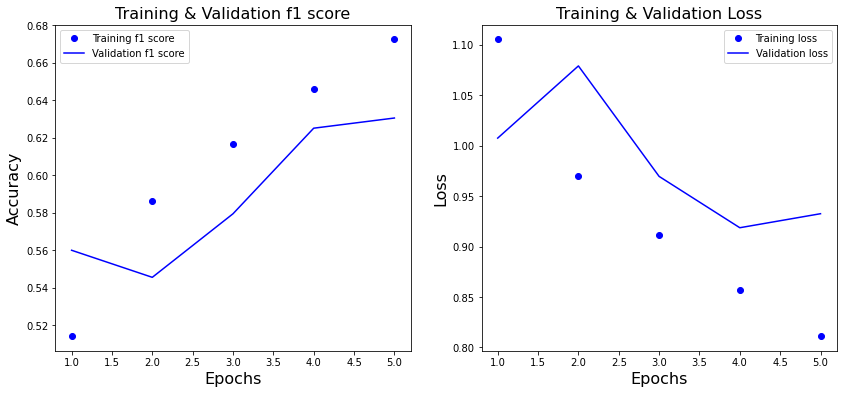

In [ ]:
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, f1, 'bo', label='Training f1 score')
ax[0].plot(epochs, val_f1, 'b', label='Validation f1 score')
ax[0].set_title('Training & Validation f1 score', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Confusion Matrix


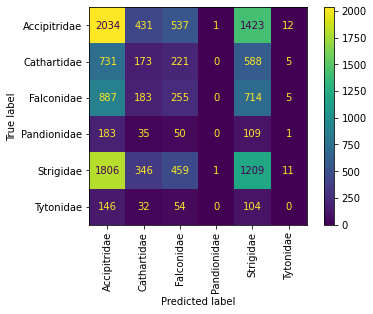

In [ ]:
images_per_class_test = np.floor(test_batches.batch_size / n_classes)

predictions = model.predict(test_batches, steps=images_per_class_test * n_classes / batch_size)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

print('Confusion Matrix')
cm = confusion_matrix(true_classes, predicted_classes)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp_cm.plot(xticks_rotation='vertical');

## Using Transfer Learning from our Pre-Trained Model to classify the images



In [ ]:
# 1st step: removing the last FC layer from the original model:
model.layers # displays all layers in the original model

In [ ]:
tl_model = Sequential()
for layer in model.layers[:-1]: # go through until last layer
    tl_model.add(layer)
tl_model.add(layers.Dense(n_classes, activation='softmax'))
tl_model.summary()
tl_model.compile(optimizer='Nadam', loss='categorical_crossentropy',  metrics=['accuracy', f1_m, recall_m, precision_m])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization_5 (Batc  (None, 110, 110, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 110, 110, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 32)        25632     
                                                                 
 batch_normalization_6 (Batc  (None, 53, 53, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 53, 53, 32)       

In [ ]:
hist = tl_model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=qt_epochs,
                validation_data = val_batches,
                validation_steps= images_per_class_val * n_classes / batch_size,              
  )

Epoch 1/5
649/649 [==============================] - 107s 161ms/step - loss: 0.9312 - accuracy: 0.6463 - f1_m: 0.6141 - recall_m: 0.5367 - precision_m: 0.7279 - val_loss: 1.0152 - val_accuracy: 0.6201 - val_f1_m: 0.6123 - val_recall_m: 0.5664 - val_precision_m: 0.6687
Epoch 2/5
649/649 [==============================] - 106s 163ms/step - loss: 0.7925 - accuracy: 0.7005 - f1_m: 0.6836 - recall_m: 0.6177 - precision_m: 0.7689 - val_loss: 0.8339 - val_accuracy: 0.6905 - val_f1_m: 0.6736 - val_recall_m: 0.6073 - val_precision_m: 0.7595
Epoch 3/5
649/649 [==============================] - 106s 163ms/step - loss: 0.7287 - accuracy: 0.7246 - f1_m: 0.7109 - recall_m: 0.6498 - precision_m: 0.7876 - val_loss: 0.8956 - val_accuracy: 0.6668 - val_f1_m: 0.6593 - val_recall_m: 0.6188 - val_precision_m: 0.7072
Epoch 4/5
649/649 [==============================] - 105s 162ms/step - loss: 0.6856 - accuracy: 0.7456 - f1_m: 0.7312 - recall_m: 0.6765 - precision_m: 0.7980 - val_loss: 0.8593 - val_accuracy:

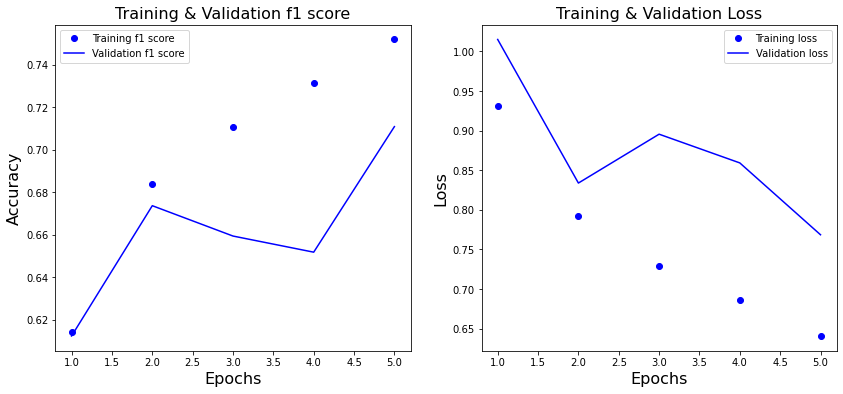

In [ ]:
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, f1, 'bo', label='Training f1 score')
ax[0].plot(epochs, val_f1, 'b', label='Validation f1 score')
ax[0].set_title('Training & Validation f1 score', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Confusion Matrix


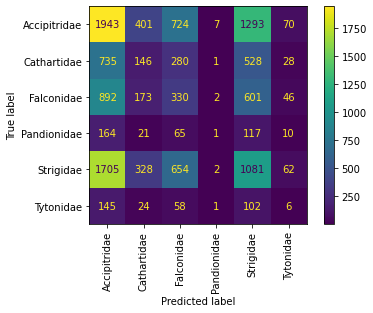

In [ ]:
images_per_class_test = np.floor(test_batches.batch_size / n_classes)

predictions = tl_model.predict(test_batches, steps=images_per_class_test * n_classes / batch_size)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

print('Confusion Matrix')
cm = confusion_matrix(true_classes, predicted_classes)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp_cm.plot(xticks_rotation='vertical');

# Using Transfer Learning with a popular Pre-Trained Model (MobileNetV2) to classify the images

In [ ]:
mobv2_model = Sequential()
mobv2_model.add(MobileNetV2(weights='imagenet'))
mobv2_model.add(layers.Dense(n_classes, activation='softmax'))
mobv2_model.summary()
mobv2_model.compile(optimizer='Nadam', loss='categorical_crossentropy',  metrics=['accuracy', f1_m, recall_m, precision_m])

14548992/14536120 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 6)                 6006      
                                                                 
Total params: 3,544,990
Trainable params: 3,510,878
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
hist = mobv2_model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * n_classes / batch_size,
                epochs=qt_epochs,
                validation_data = val_batches,
                validation_steps= images_per_class_val * n_classes / batch_size,              
  )

Epoch 1/5
649/649 [==============================] - 291s 422ms/step - loss: 1.4691 - accuracy: 0.5550 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 1.6292 - val_accuracy: 0.3317 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/5
649/649 [==============================] - 271s 417ms/step - loss: 1.2224 - accuracy: 0.5807 - f1_m: 0.3756 - recall_m: 0.2433 - precision_m: 0.8490 - val_loss: 1.9431 - val_accuracy: 0.3010 - val_f1_m: 0.3012 - val_recall_m: 0.3012 - val_precision_m: 0.3012
Epoch 3/5
649/649 [==============================] - 270s 416ms/step - loss: 1.1159 - accuracy: 0.5976 - f1_m: 0.3921 - recall_m: 0.2545 - precision_m: 0.8831 - val_loss: 2.2301 - val_accuracy: 0.3015 - val_f1_m: 0.3010 - val_recall_m: 0.3008 - val_precision_m: 0.3011
Epoch 4/5
649/649 [==============================] - 271s 417ms/step - loss: 1.0626 - accuracy: 0.6088 - f1_m: 0.4008 - recall_m: 0.2605 - precision_m: 0.9005 - val_loss

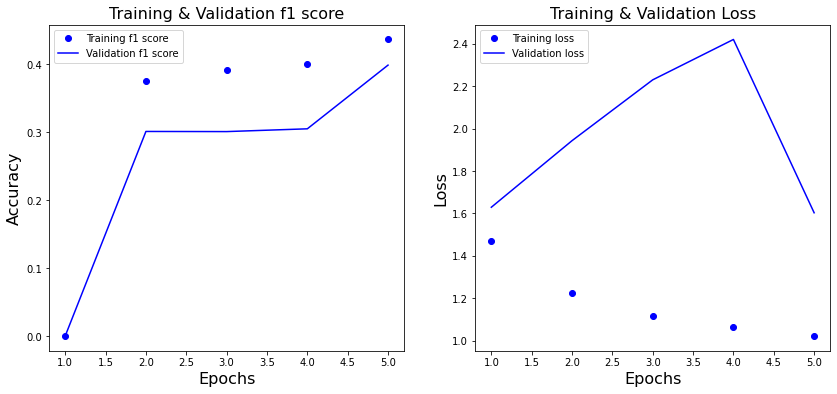

In [ ]:
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
f1 = history_dict['f1_m']
val_f1 = history_dict['val_f1_m']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, f1, 'bo', label='Training f1 score')
ax[0].plot(epochs, val_f1, 'b', label='Validation f1 score')
ax[0].set_title('Training & Validation f1 score', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Confusion Matrix


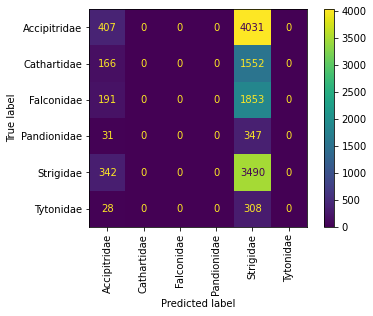

In [ ]:
images_per_class_test = np.floor(test_batches.batch_size / n_classes)

predictions = mobv2_model.predict(test_batches, steps=images_per_class_test * n_classes / batch_size)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_batches.classes
class_labels = list(test_batches.class_indices.keys())

print('Confusion Matrix')
cm = confusion_matrix(true_classes, predicted_classes)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp_cm.plot(xticks_rotation='vertical');